In [1]:
import librosa
import pydub
import os
from pydub.audio_segment import AudioSegment
from pydub.utils import make_chunks
from scipy.signal import spectrogram
from librosa.effects import preemphasis
import numpy as np
import matplotlib.pyplot as plt
from librosa import display
from sklearn.model_selection import train_test_split
from skimage import data, io, filters
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, MaxPooling1D, LocallyConnected1D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint

C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Step 1: Segmenting audio file into 500ms chunks (code modified from: https://stackoverflow.com/questions/51060460/split-wav-file-in-python-with-different-start-and-end-duration)

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        save_file_name = filename[:-4]
        myaudio = AudioSegment.from_wav(directory+"/"+filename) 
        chunk_length_ms = 500 # pydub calculates in millisec
        chunks = make_chunks(myaudio, chunk_length_ms)
        # saving then to output dir.
        for i, chunk in enumerate(chunks):
            chunk_name = save_file_name+"_{0}.wav".format(i)
            #print(chunk_name)
            parts = chunk_name.split('_')  
            a = parts[-1].split('.')
            b = a[0]
            if(len(b) == 1):
                b = "0"+b
            chunk_name = parts[0]+"_"+parts[1]+"_"+b+".wav"
            #print(chunk_name)
            print("exporting", chunk_name)
            chunk.export(outputdir+"/"+chunk_name, format="wav")

Step 2: Generating Mel Spectrograms from the audio chunks (Code obtained from Librosa documentation)

In [ ]:
from librosa.effects import trim
for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        y, sr = librosa.load(directory+filename)
        yt, index = trim(y)
        S = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=256, n_fft = 2048, hop_length=32,
                                   fmax=8000)
        plt.figure(figsize=(5, 5))
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB,sr=sr,
                             fmax=8000)
        plt.tight_layout()
        plt.savefig(filename[:-4]+".png")
        plt.close()


Step 3: Recurrent Feature Elimination on openSMILE features (Code modified from: https://www.programcreek.com/python/example/86795/sklearn.feature_selection.RFE)

In [ ]:
df = pd.read_csv("ouputSVPT.csv")

labels =[]

for name in df["name"]:
    if "-PT-" in str(name):
        labels.append("0")
    elif "-RT-" in str(name):
        labels.append("1")
        
df = df.drop(["name", "class"], axis=1)

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model)
X_rfe = rfe.fit(df2,labels)


print("Num Features: %d" % X_rfe.n_features_)
print("Selected Features: %s" % X_rfe.support_)
print("Feature Ranking: %s" % X_rfe.ranking_)

rankings = list(X_rfe.ranking_)

feature_indexes=[]
for i in range(len(rankings)):
    if rankings[i]==1:
        feature_indexes+=[i]


Step 4: Preparing features for classification

In [ ]:
df = pd.read_csv("SVPTfeatures273.csv")
data = df.values.tolist()

X_train = data[:957]
X_test = data[958:]
X_train= np.array(X)
X_test = np.array(X_)
Y_train = labels[:957]
Y_test = labels[958:]
Y_train = np.array(Y_train)
Y_train = to_categorical(Y_train)
Y_test = np.array(Y_test)
Y_test = to_categorical(Y_test)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))



x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.10, shuffle= True)


Step 5: Defining model architecture for Featural data

In [ ]:
model = Sequential()
batch_size = 128
filepath="weights.best.hdf5"
data_dim = 273
timesteps = 1
num_classes = 2



model.add(BatchNormalization(input_shape=(timesteps, data_dim)))
model.add(Conv1D(32,3, data_format="channels_first", use_bias=True))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Conv1D(64,3, data_format="channels_first", use_bias=True))
model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.35))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

adadela = optimizers.adadelta()
model.compile(loss='binary_crossentropy', optimizer=adadelta,
              metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callback = [checkpoint]


In [ ]:
model.fit(x_train, y_train,
          epochs=100,
          batch_size=batch_size, shuffle=True,
         validation_data=(x_valid,y_valid), callbacks = callback
         )

Step 6: Test the model and obtain results

In [ ]:
predictions = model.predict_classes(X_test)
predictions = [str(a) for a in predictions]
gold = labels[958:]


In [201]:
sum(1 for x,y in zip(predictions,gold) if x == y) / float(len(predictions))

0.7012987012987013

In [222]:
precision_recall_fscore_support(gold, predictions)

(array([0.58666667, 0.81012658]),
 array([0.74576271, 0.67368421]),
 array([0.65671642, 0.73563218]),
 array([59, 95], dtype=int64))

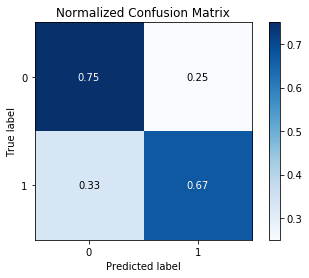

In [294]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(gold, predictions, normalize=True)

Step 7: Load spectral data

In [ ]:

directory = "C:/Users/A/Desktop/Participants/svptpng/"
files = []
labels =[]
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        files.append(str(filename))
        if "-PT-" in filename:
            labels.append("0")
        elif "-RT-" in filename:
            labels.append("1")

path = "C:/Users/A/Desktop/Participants/svptpng/"
all_images = []
for image_path in os.listdir(path):
    if image_path.endswith("png"):
        img = io.imread(path+image_path , as_gray=False)
        all_images.append(img)
x_train = np.array(all_images)

path = "C:/Users/A/Desktop/Participants/svptpng/PM4/"
all_images = []
for image_path in os.listdir(path):
    if image_path.endswith("png"):
        img = io.imread(path+image_path , as_gray=False)
        all_images.append(img)
X_test = np.array(all_images)


directory = "C:/Users/A/Desktop/Participants/svptpng/PM4"
vabels =[]
for filename in os.listdir(directory):
    if filename.endswith(".png"):
        files.append(str(filename))
        if "-PT-" in filename:
            vabels.append("0")
        elif "-RT-" in filename:
            vabels.append("1")

            
Y_val = np.array(Y_val)
Y_train = np.array(Y_train)

Y_val = to_categorical(Y_val)
Y_train = to_categorical(Y_train)

#Normalize the image data
X_val = X_val/255.0
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
model = Sequential()
batch_size = 64
filepath = "new_model.hdf5"

model.add(Conv2D(32, (3, 3), input_shape=(360,360,4),data_format="channels_first",use_bias=True,kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())  #

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

adam = optimizers.adadelta()
model.compile(loss='binary_crossentropy', optimizer=adam,
              metrics=['accuracy'])
keras.callbacks.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

model.fit(X_train, Y_train,
          epochs=30,
          batch_size=batch_size,
         validation_data=(X_val,Y_val))

Step 8: Fully train the data

In [28]:
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=batch_size,
         validation_data=(X_val,Y_val))

Train on 864 samples, validate on 96 samples
Epoch 1/20
864/864 [==============================] - 12s 14ms/step - loss: 0.5865 - accuracy: 0.6881 - val_loss: 0.5974 - val_accuracy: 0.6198
Epoch 2/20
864/864 [==============================] - 11s 12ms/step - loss: 0.5885 - accuracy: 0.6759 - val_loss: 0.6528 - val_accuracy: 0.5938
Epoch 3/20
864/864 [==============================] - 11s 13ms/step - loss: 0.6320 - accuracy: 0.6169 - val_loss: 0.6226 - val_accuracy: 0.6302
Epoch 4/20
864/864 [==============================] - 11s 13ms/step - loss: 0.5466 - accuracy: 0.7170 - val_loss: 0.5762 - val_accuracy: 0.6823
Epoch 5/20
864/864 [==============================] - 11s 12ms/step - loss: 0.5496 - accuracy: 0.7083 - val_loss: 0.5484 - val_accuracy: 0.7448
Epoch 6/20
864/864 [==============================] - 11s 12ms/step - loss: 0.5045 - accuracy: 0.7419 - val_loss: 0.5216 - val_accuracy: 0.7604
Epoch 7/20
864/864 [==============================] - 12s 13ms/step - loss: 0.6235 - accura

In [ ]:
model.predict_classes(X_test)
predictions = [str(a) for a in predictions]

In [59]:
sum(1 for x,y in zip(predictions,vabels) if x == y) / float(len(predictions))

0.7290322580645161

In [60]:
>>> import numpy as np
>>> from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(vabels, predictions)

(array([0.67307692, 0.75728155]),
 array([0.58333333, 0.82105263]),
 array([0.625     , 0.78787879]),
 array([60, 95], dtype=int64))